In [1]:
import openmc
model = openmc.Model()

In [13]:
#--------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------MATERIALS-----------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------
lead = openmc.Material(name='lead')
lead.add_element('Pb', 1.0 , percent_type='ao') # Incomplete
lead.set_density('g/cm3', 11.348 )

materials = openmc.Materials([lead])
print(lead)

Material
	ID             =	3
	Name           =	lead
	Temperature    =	None
	Density        =	11.348 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Pb204          =	0.014        [ao]
	Pb206          =	0.241        [ao]
	Pb207          =	0.221        [ao]
	Pb208          =	0.524        [ao]




 Current Experiment: neutron source infront of lead shield of thickness 0 cm 

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 ####

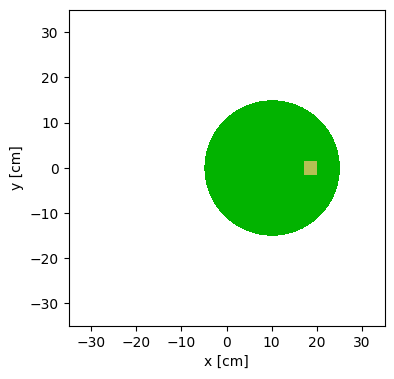

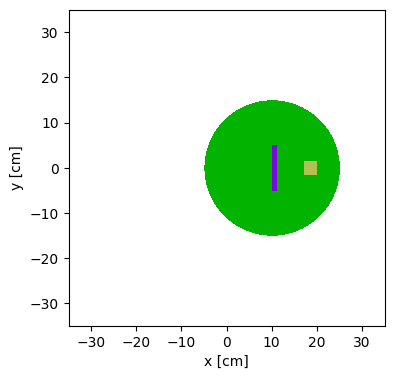

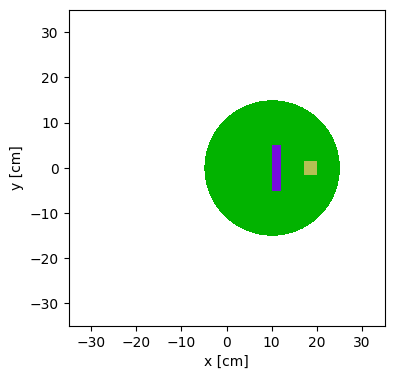

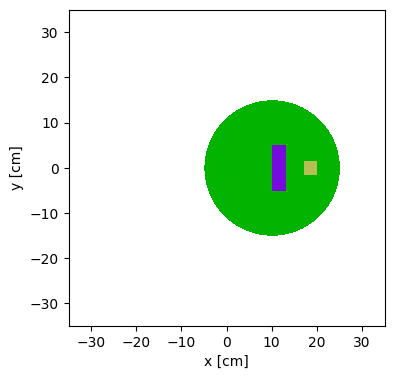

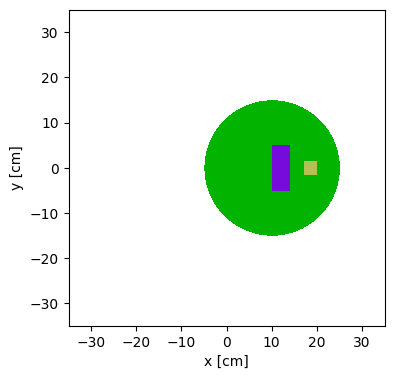

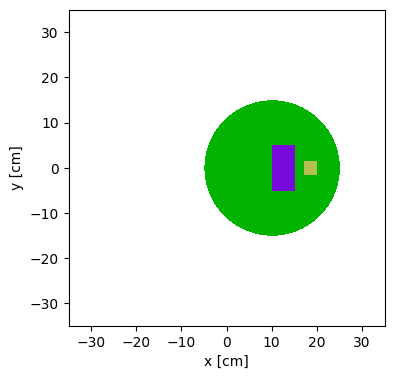

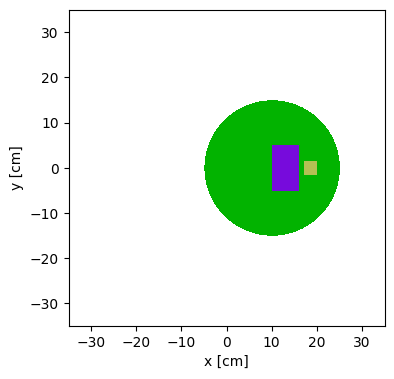

In [23]:
#--------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------GEOMETRY------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------------------------------
detector_cylinder = openmc.XCylinder(r=1.5, boundary_type='vacuum') # radius of the window
detector_window = openmc.XPlane(x0=17, boundary_type='transmission') # Distance between source & Detector's window (Tallies will be at this surface)
detector_window_end = openmc.XPlane(x0=20, boundary_type='vacuum') # End of the detector's tube

detector = openmc.Cell()
detector.region = +detector_window & -detector_window_end & -detector_cylinder # Tube shape

shield_front = openmc.XPlane(x0=10, boundary_type='transmission')
shield_top = openmc.ZPlane(z0=-5, boundary_type='vacuum')
shield_bottom = openmc.ZPlane(z0=5, boundary_type='vacuum') # delta Z = height
shield_left = openmc.YPlane(y0=-5, boundary_type='vacuum')
shield_right = openmc.YPlane(y0=5, boundary_type='vacuum') # delta Y = width

for t in [10,11,12,13,14,15,16]:
    shield_back = openmc.XPlane(x0=t, boundary_type='transmission') # delta X = thickness

    
    shield = openmc.Cell(fill=lead)
    shield.region = +shield_front & -shield_back & +shield_top & -shield_bottom & +shield_left & -shield_right # Cuboid shape
    sphere_region = openmc.Sphere(x0=10,r=15, boundary_type='vacuum')
    sphere = openmc.Cell(region=-sphere_region & ~detector.region & ~shield.region)
    geometry = openmc.Geometry([shield, detector, sphere])
    root_universe = openmc.Universe(cells=[shield, detector, sphere])
    root_universe.plot((0, 0, 0), width=(70, 70), pixels=100000, basis='xy')

    #--------------------------------------------------------------------------------------------------------------------------
    #------------------------------------------------SOURCES-------------------------------------------------------------------
    #--------------------------------------------------------------------------------------------------------------------------
    
    src_type = {1:'neutron' , 2:'photon'} # Dictionary useful when looping and outputing current run experiment
    
    for src in src_type.keys():
    
        tallies = openmc.Tallies() # Early tallies intialization for looping over the particle filter
        settings = openmc.Settings() # Early settings intialization for looping over the source type
        
        if src == 1:
            neutron_source = openmc.IndependentSource()
            neutron_source.particle = 'neutron'
            neutron_source.angle = openmc.stats.Monodirectional((1,0,0))
            neutron_source.space = openmc.stats.Point((0,0,0))
            neutron_source.energy = openmc.stats.Discrete([0.0253],[1.0]) # thermal 0.0253eV Energy
            openmc.settings.source = neutron_source
            particle_filter = openmc.ParticleFilter(['neutron']) #---Change when changing the source
            settings.source = neutron_source
        else:
            photon_source = openmc.IndependentSource()
            photon_source.particle = 'photon'
            photon_source.angle = openmc.stats.Monodirectional((1,0,0))
            photon_source.space = openmc.stats.Point((0,0,0))
            photon_source.energy = openmc.stats.Discrete([1e6],[1.0]) # 1 MeV Energy
            openmc.settings.source = photon_source
            particle_filter = openmc.ParticleFilter(['photon']) #---Change when changing the source
            settings.source = photon_source
        
        #--------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------TALLIES-------------------------------------------------------------------
        #-------------------------------------------------------------------------------------------------------------------------
        
        # Surface current tally on back face of lead shield
        surface_filter = openmc.SurfaceFilter(detector_window_end.id)
        current_tally = openmc.Tally(name='Current Tally')
        current_tally.filters = [surface_filter,particle_filter]
        current_tally.scores = ['current']
        tallies.append(current_tally)
    
        #--------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------SETTINGS------------------------------------------------------------------
        #--------------------------------------------------------------------------------------------------------------------------
        
        
        settings.run_mode = 'fixed source'
        settings.batches = 100
        settings.particles = 100000
    
        model = openmc.Model(
        geometry=geometry,
        materials=materials,
        settings=settings,
        tallies=tallies
        )
        print(f"\n Current Experiment: {src_type[src]} source infront of lead shield of thickness {t-10} cm \n") #---INDICATING CURRENT RUN
        
        model.run()
    
        #--------------------------------------------------------------------------------------------------------------------------
        #------------------------------------------------DATA EXTRACTION-----------------------------------------------------------
        #--------------------------------------------------------------------------------------------------------------------------
        
        with openmc.StatePoint('statepoint.100.h5') as sp:
            current = sp.get_tally(name="Current Tally").mean.flat[0]
        
        print(f"Net Current: {current:.7e} n/s")
    